# Fake News Detector

Determining if a body of text is real or fake involves some subjectivity. My analysis is based on these assumptions:
1. Fake news will include stronger, more persuasive language than real news
    - The thought here is that fake news is meant to evoke stronger emotion so that people are more likely to share it.
2. Fake news won't be as well written as real news
    - When news comes from trusted sources, the  thought is that it must pass some editorial standard. At this point in time, the assumption is that fake news doesn't have this same type of limitation before it is released into the public.

In [92]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import bz2

In [2]:
#check what directory we're in:
os.getcwd()

'/Users/emensahb/Documents/Efua/Computer Science/Data Science/Springboard/Assignments/Capstone 2/Fake News Detector'

# Data Wrangling

File sources:
<ul>
    <li>Kaggle: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset (fake, news)</li>
    <li>Kaggle: https://www.kaggle.com/mrisdal/fake-news?select=fake.csv (fake1)</li>
    <li>News: https://drive.google.com/file/d/1er9NJTLUA3qnRuyhfzuN0XUsoIC4a-_q/view (true)</li>
</ul>

### Import files as dataframes

In [3]:
#First import news.csv
news = pd.read_csv('news.csv')
news.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
news.describe()

,Unnamed: 0
count,6335.000000
mean,5280.415627
std,3038.503953
min,2.000000
25%,2674.500000
50%,5271.000000
75%,7901.000000
max,10557.000000


In [5]:
# Check out the shape
news.shape

(6335, 4)

In [6]:
news = news.drop(['Unnamed: 0'], axis=1)
news.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [7]:
#check the dtype of each field make sure it's as expected. 
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 148.6+ KB


In [8]:
# Next import fake.csv
fake = pd.read_csv('fake.csv')
fake.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [9]:
fake.describe()

,ord_in_thread,domain_rank,spam_score,replies_count,participants_count,likes,comments,shares
count,12999.000000,8776.000000,12999.000000,12999.000000,12999.000000,12999.000000,12999.000000,12999.000000
mean,0.891530,38092.996582,0.026122,1.383183,1.727518,10.831833,0.038311,10.831833
std,6.486822,26825.487454,0.122889,9.656838,6.884239,79.798949,0.827335,79.798949
min,0.000000,486.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,17423.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,34478.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,60570.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,100.000000,98679.000000,1.000000,309.000000,240.000000,988.000000,65.000000,988.000000


In [10]:
fake.shape

(12999, 20)

In [11]:
#add a label column and populate it with 'FAKE'
fake['label']= 'FAKE'
fake.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,...,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,label
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,...,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,FAKE
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,...,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,FAKE
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,...,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,FAKE
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,...,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,FAKE
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,...,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,FAKE


In [12]:
#What are the fake columns
fake.columns

Index(['uuid', 'ord_in_thread', 'author', 'published', 'title', 'text',
       'language', 'crawled', 'site_url', 'country', 'domain_rank',
       'thread_title', 'spam_score', 'main_img_url', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'type', 'label'],
      dtype='object')

In [13]:
#create a new fake database dropping all fields except title,text,label
fake = fake.drop(['uuid', 'ord_in_thread', 'author', 'published',
     'language', 'crawled', 'site_url', 'country', 'domain_rank',
       'thread_title', 'spam_score', 'main_img_url', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'type'], axis=1)
fake.head()


,title,text,label
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,FAKE
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,FAKE
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,FAKE
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,FAKE
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,FAKE


In [14]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12999 entries, 0 to 12998
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   12319 non-null  object
 1   text    12953 non-null  object
 2   label   12999 non-null  object
dtypes: object(3)
memory usage: 304.8+ KB


In [15]:
#load in new files
fake1 = pd.read_csv('Fake1.csv')
fake1.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [16]:
fake1.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [17]:
fake1.shape

(23481, 4)

In [18]:
#add a label column and populate it with 'FAKE'
fake1['label']= 'FAKE'
fake1.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",FAKE
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",FAKE
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",FAKE
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",FAKE
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",FAKE


In [19]:
#What are the fake1 columns
fake1.columns

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

In [20]:
#create a new fake database dropping all fields except title,text,label
fake1 = fake1.drop(['subject', 'date'], axis=1)
fake1.head()


,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,FAKE
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,FAKE
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",FAKE
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",FAKE
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,FAKE


In [21]:
#check the dtype of each field make sure it's as expected. 
fake1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   23481 non-null  object
 1   text    23481 non-null  object
 2   label   23481 non-null  object
dtypes: object(3)
memory usage: 550.5+ KB


In [22]:
true = pd.read_csv('True.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [23]:
true.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


In [24]:
true.shape

(21417, 4)

In [25]:
#add a label column and populate it with 'REAL'
true['label']= 'REAL'
true.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",REAL
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",REAL
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",REAL
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",REAL
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",REAL


In [26]:
#What are the true columns
true.columns

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

In [27]:
#create a new fake database dropping all fields except title, text, label
true = true.drop(['subject', 'date'], axis=1)
true.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,REAL
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,REAL
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,REAL
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,REAL
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,REAL


In [28]:
#check the dtype of each field make sure it's as expected. 
true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   21417 non-null  object
 1   text    21417 non-null  object
 2   label   21417 non-null  object
dtypes: object(3)
memory usage: 502.1+ KB


### Join tables into one dataframe

In [29]:
frames = [news, fake, fake1, true]

In [30]:
df = pd.concat(frames)
df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64232 entries, 0 to 21416
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   63552 non-null  object
 1   text    64186 non-null  object
 2   label   64232 non-null  object
dtypes: object(3)
memory usage: 2.0+ MB


In [32]:
# It seems we have some NA values. Delete all rows with NA values
df = df.dropna()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63506 entries, 0 to 21416
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   63506 non-null  object
 1   text    63506 non-null  object
 2   label   63506 non-null  object
dtypes: object(3)
memory usage: 1.9+ MB


# Exploratory Data Analysis

### Things to explore
For this fake new dectector, I'd like to evaluate the label, title and text. basically all the columns in the dataframe.

Things I'd like to explore:
1. Data balance
2. Most common no. of characters in title
3. Most frequently appearing words in title and text (excluding stop words)
3. Words occuring commonly in corpus as well as other corpuses (Inverse Document Frequency)
4. Word collocation (n-gram analysis) in title and text
6. Text Classification
     Topic analysis Most common topics in real and fake (Latent Dirichlet Allocation(LDA)) 
     Intent analysis
     Keyword extraction
7. Word cloud for fake and real

In [34]:
# check how balanced the data is
df.label.value_counts()

FAKE    38918
REAL    24588
Name: label, dtype: int64

(array([38918., 24588.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

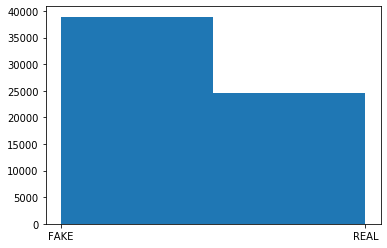

In [35]:
# get a visual for the data balance
plt.hist(df.label, bins=2)

In [36]:
df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


### No. of characters

In [37]:
# How many characters in title. This is a topic for copywriters. 
#They tend to know what words and characters tend to work best for readers. Is this same thought used here?

df['title_char'] = df['title'].str.len()
df.head()

,title,text,label,title_char
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,28
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,85
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,43
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,84
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,48


In [38]:
# Filtering Real titles
rt = df.title_char[df.label =='REAL']

In [39]:
# Filtering Fake titles
ft = df.title_char[df.label =='FAKE']

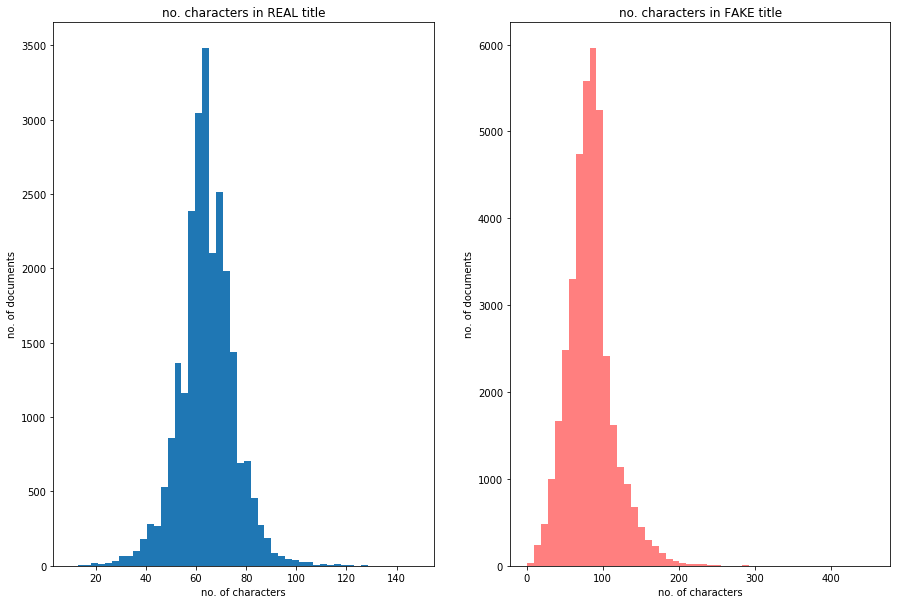

In [40]:
#plot number of characters in real and fake titles
n_bins=50
fig_size=(15,10)
fig, axs = plt.subplots(1, 2, figsize=fig_size)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(rt, bins=n_bins)
axs[0].set_title('no. characters in REAL title')
axs[1].hist(ft, bins=n_bins, color='red', alpha=0.5)
axs[1].set_title('no. characters in FAKE title')


for ax in axs.flat:
    ax.set(xlabel='no. of characters', ylabel='no. of documents')

In [41]:
# Repeat the process for no. of characters in text to see if there is anything noticeable
df['text_char'] = df['text'].str.len()
df.head()

,title,text,label,title_char,text_char
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,28,7518
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,85,2646
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,43,2543
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,84,2660
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,48,1840


In [42]:
# Filtering Real text
rtx = df.text_char[df.label =='REAL']

In [43]:
# Filtering Fake text
ftx = df.title_char[df.label =='FAKE']

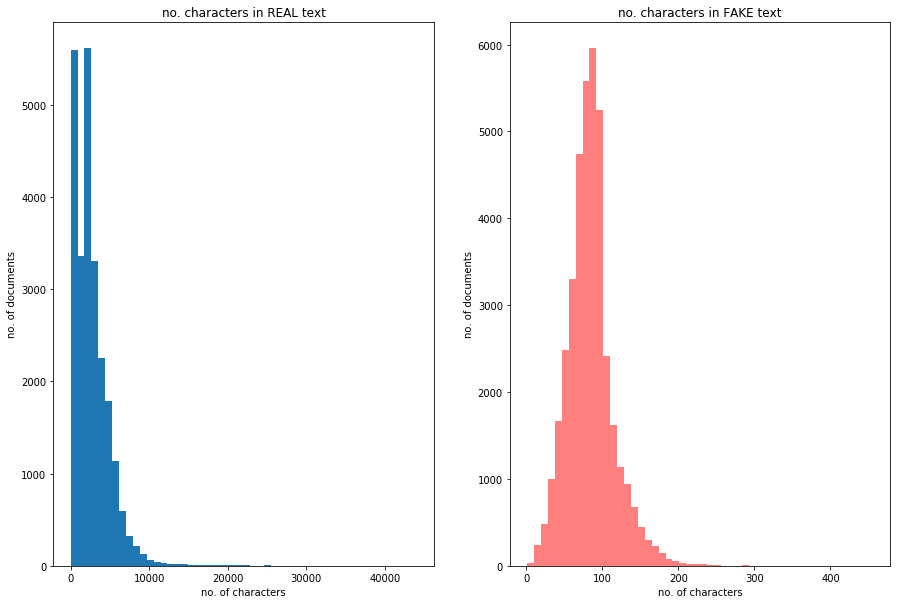

In [44]:
#plot number of characters in real and fake text
n_bins=50
fig_size=(15,10)
fig, axs = plt.subplots(1, 2, figsize=fig_size)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(rtx, bins=n_bins)
axs[0].set_title('no. characters in REAL text')
axs[1].hist(ftx, bins=n_bins, color='red', alpha=0.5)
axs[1].set_title('no. characters in FAKE text')


for ax in axs.flat:
    ax.set(xlabel='no. of characters', ylabel='no. of documents')


### No. of words

Will count the frequency of words in both title and text. To do this:
1. Remove stop words
2. Count words in title and text
3. Display top 20 words used in title and then text

In [45]:
#remove punctuation from title
df["new_title"] = df['title'].str.replace('[^\w\s]','')


In [46]:
#remove punctuation from text
df["new_text"] = df['text'].str.replace('[^\w\s]','')

In [47]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emensahb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
#remove stop words from title
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['new_title'] = df['new_title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head()

,title,text,label,title_char,text_char,new_title,new_text
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,28,7518,You Can Smell Hillarys Fear,Daniel Greenfield a Shillman Journalism Fellow...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,85,2646,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,43,2543,Kerry go Paris gesture sympathy,US Secretary of State John F Kerry said Monday...
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,84,2660,Bernie supporters Twitter erupt anger DNC We t...,Kaydee King KaydeeKing November 9 2016 The le...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,48,1840,The Battle New York Why This Primary Matters,Its primary day in New York and frontrunners H...


In [49]:
#remove stop words from text
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['new_text'] = df['new_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head()

,title,text,label,title_char,text_char,new_title,new_text
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,28,7518,You Can Smell Hillarys Fear,Daniel Greenfield Shillman Journalism Fellow F...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,85,2646,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,43,2543,Kerry go Paris gesture sympathy,US Secretary State John F Kerry said Monday st...
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,84,2660,Bernie supporters Twitter erupt anger DNC We t...,Kaydee King KaydeeKing November 9 2016 The les...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,48,1840,The Battle New York Why This Primary Matters,Its primary day New York frontrunners Hillary ...


In [50]:
#convert everything in the title to lowercase
df['new_title']= df['new_title'].str.lower()
df.head()

,title,text,label,title_char,text_char,new_title,new_text
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,28,7518,you can smell hillarys fear,Daniel Greenfield Shillman Journalism Fellow F...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,85,2646,watch the exact moment paul ryan committed pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,43,2543,kerry go paris gesture sympathy,US Secretary State John F Kerry said Monday st...
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,84,2660,bernie supporters twitter erupt anger dnc we t...,Kaydee King KaydeeKing November 9 2016 The les...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,48,1840,the battle new york why this primary matters,Its primary day New York frontrunners Hillary ...


In [51]:
#convert everything in the text to lowercase
df['new_text']= df['new_text'].str.lower()
df.head()

,title,text,label,title_char,text_char,new_title,new_text
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,28,7518,you can smell hillarys fear,daniel greenfield shillman journalism fellow f...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,85,2646,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,43,2543,kerry go paris gesture sympathy,us secretary state john f kerry said monday st...
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,84,2660,bernie supporters twitter erupt anger dnc we t...,kaydee king kaydeeking november 9 2016 the les...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,48,1840,the battle new york why this primary matters,its primary day new york frontrunners hillary ...


In [52]:
#Count words in each title
df['title_word_count'] = df['new_title'].str.split(" ").str.len()
df.head()


,title,text,label,title_char,text_char,new_title,new_text,title_word_count
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,28,7518,you can smell hillarys fear,daniel greenfield shillman journalism fellow f...,5
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,85,2646,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,14
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,43,2543,kerry go paris gesture sympathy,us secretary state john f kerry said monday st...,5
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,84,2660,bernie supporters twitter erupt anger dnc we t...,kaydee king kaydeeking november 9 2016 the les...,9
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,48,1840,the battle new york why this primary matters,its primary day new york frontrunners hillary ...,8


In [53]:
#Count words in each title
df['text_word_count'] = df['new_text'].str.split(" ").str.len()
df.head()

,title,text,label,title_char,text_char,new_title,new_text,title_word_count,text_word_count
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,28,7518,you can smell hillarys fear,daniel greenfield shillman journalism fellow f...,5,749
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,85,2646,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,14,259
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,43,2543,kerry go paris gesture sympathy,us secretary state john f kerry said monday st...,5,257
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,84,2660,bernie supporters twitter erupt anger dnc we t...,kaydee king kaydeeking november 9 2016 the les...,9,274
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,48,1840,the battle new york why this primary matters,its primary day new york frontrunners hillary ...,8,195


In [54]:
#filter out number of words in title
rwc = df.title_word_count[df.label =='REAL']
fwc = df.title_word_count[df.label =='FAKE']

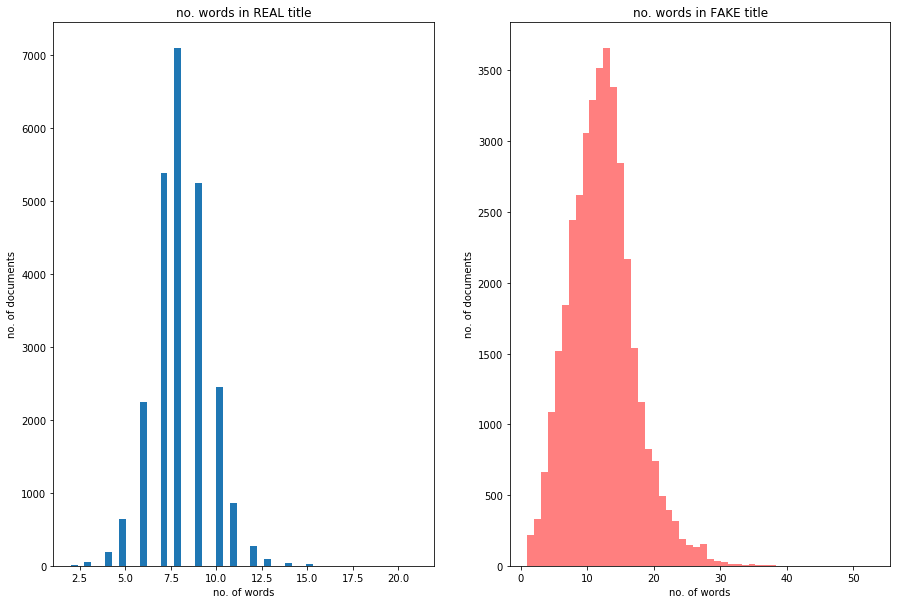

In [55]:
#plot number of words in real and fake titles
n_bins=50
fig_size=(15,10)
fig, axs = plt.subplots(1, 2, figsize=fig_size)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(rwc, bins=n_bins)
axs[0].set_title('no. words in REAL title')
axs[1].hist(fwc, bins=n_bins, color='red', alpha=0.5)
axs[1].set_title('no. words in FAKE title')


for ax in axs.flat:
    ax.set(xlabel='no. of words', ylabel='no. of documents')

In [56]:
#filter out number of words in text 
rwcx = df.text_word_count[df.label =='REAL']
fwcx = df.text_word_count[df.label =='FAKE']

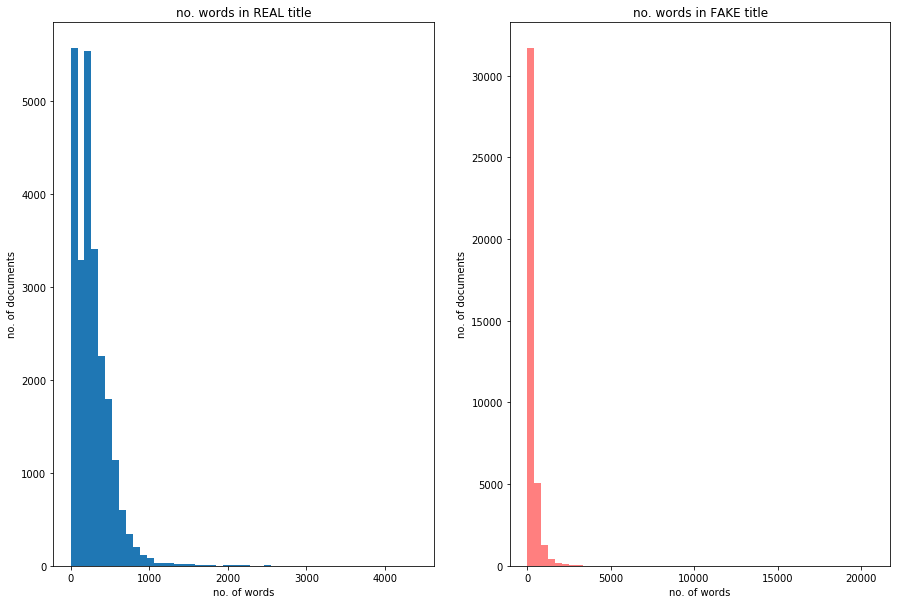

In [57]:
#plot number of words in real and fake text
n_bins=50
fig_size=(15,10)
fig, axs = plt.subplots(1, 2, figsize=fig_size)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(rwcx, bins=n_bins)
axs[0].set_title('no. words in REAL title')
axs[1].hist(fwcx, bins=n_bins, color='red', alpha=0.5)
axs[1].set_title('no. words in FAKE title')


for ax in axs.flat:
    ax.set(xlabel='no. of words', ylabel='no. of documents')

### Word Frequency
When I look at the data collected what words appear most frequently in the fake news titles and text and in real news titles and text

In [58]:
#first remove stop words from title and text
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emensahb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/emensahb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [59]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop = stopwords.words('english')

In [60]:
#filter out real titles
nt = df.new_title[df.label =='REAL']
nt.head()

2                      kerry go paris gesture sympathy
4         the battle new york why this primary matters
7                          britains schindler dies 106
8      fact check trump clinton commanderinchief forum
9    iran reportedly makes new push uranium concess...
Name: new_title, dtype: object

In [61]:
#filter out fake titles
ft = df.new_title[df.label =='FAKE']
ft.head()

0                          you can smell hillarys fear
1    watch the exact moment paul ryan committed pol...
3    bernie supporters twitter erupt anger dnc we t...
5                                           tehran usa
6    girl horrified at what she watches boyfriend d...
Name: new_title, dtype: object

In [62]:
#find the most common words in real titles (excluding stop words)
corpus = []
for i in range(len(nt)):
    title = nt.iloc[i]
    text_tokens = word_tokenize(title)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
    for j in range(len(tokens_without_sw)):
        corpus.append(tokens_without_sw[j])
print(corpus[:10])

['kerry', 'go', 'paris', 'gesture', 'sympathy', 'battle', 'new', 'york', 'primary', 'matters']


In [63]:
#get the most common words used in real titles
from collections import Counter 
Counter = Counter(corpus) 
mc_real_title = Counter.most_common(20) 
mc_real_title

[('trump', 5263),
 ('us', 4155),
 ('says', 3082),
 ('house', 1554),
 ('new', 1016),
 ('clinton', 941),
 ('north', 928),
 ('white', 899),
 ('russia', 824),
 ('korea', 805),
 ('obama', 804),
 ('trumps', 788),
 ('senate', 785),
 ('court', 772),
 ('bill', 738),
 ('state', 706),
 ('republican', 702),
 ('deal', 637),
 ('tax', 627),
 ('china', 619)]

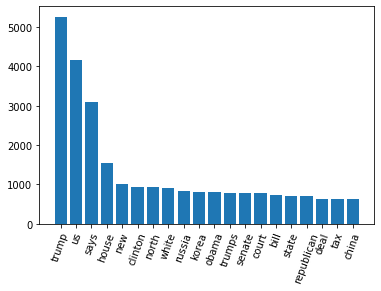

In [64]:
plt.bar(range(len(mc_real_title)), [val[1] for val in mc_real_title], align='center')
plt.xticks(range(len(mc_real_title)), [val[0] for val in mc_real_title])
plt.xticks(rotation=70)
plt.show()

In [65]:
#find the most common words in fake titles (excluding stop words)
corpus_fake = []
for i in range(len(ft)):
    title = ft.iloc[i]
    text_tokens = word_tokenize(title)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
    for j in range(len(tokens_without_sw)):
        corpus_fake.append(tokens_without_sw[j])
print(corpus_fake[:10])

['smell', 'hillarys', 'fear', 'watch', 'exact', 'moment', 'paul', 'ryan', 'committed', 'political']


In [66]:
#get the most common words used in real titles
from collections import Counter 
Counter_fake = Counter(corpus_fake) 
mc_fake_title = Counter_fake.most_common(20) 
mc_fake_title

[('trump', 9128),
 ('video', 8887),
 ('hillary', 3215),
 ('clinton', 2237),
 ('obama', 2150),
 ('watch', 2075),
 ('us', 1922),
 ('trumps', 1735),
 ('new', 1563),
 ('news', 1398),
 ('president', 1302),
 ('donald', 1241),
 ('breaking', 1153),
 ('election', 1151),
 ('black', 1083),
 ('white', 1012),
 ('fbi', 906),
 ('media', 892),
 ('america', 855),
 ('gop', 817)]

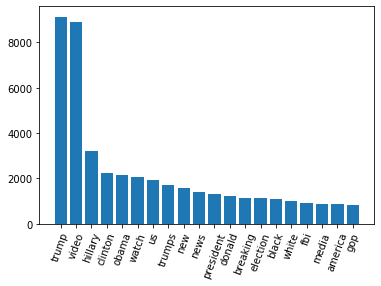

In [67]:
plt.bar(range(len(mc_fake_title)), [val[1] for val in mc_fake_title], align='center')
plt.xticks(range(len(mc_fake_title)), [val[0] for val in mc_fake_title])
plt.xticks(rotation=70)
plt.show()

In [68]:
#filter out real text
ntx = df.new_text[df.label =='REAL']
ntx.head()

2    us secretary state john f kerry said monday st...
4    its primary day new york frontrunners hillary ...
7    a czech stockbroker saved 650 jewish children ...
8    hillary clinton donald trump made inaccurate c...
9    iranian negotiators reportedly made lastditch ...
Name: new_text, dtype: object

In [69]:
#filter out fake text
ftx = df.new_text[df.label =='FAKE']
ftx.head()

0    daniel greenfield shillman journalism fellow f...
1    google pinterest digg linkedin reddit stumbleu...
3    kaydee king kaydeeking november 9 2016 the les...
5    im immigrant grandparents more 50 years ago ar...
6    share this baylee luciani left screenshot bayl...
Name: new_text, dtype: object

In [70]:
#find the most common words in real text (excluding stop words)
corpus_rx = []
for i in range(len(ntx)):
    title = ntx.iloc[i]
    text_tokens = word_tokenize(title)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
    for j in range(len(tokens_without_sw)):
        corpus_rx.append(tokens_without_sw[j])
print(corpus_rx[:10])

['us', 'secretary', 'state', 'john', 'f', 'kerry', 'said', 'monday', 'stop', 'paris']


In [71]:
#get the most common words used in real text
from collections import Counter 
Counter = Counter(corpus_rx) 
mc_real_text = Counter.most_common(20) 
mc_real_text

[('said', 116226),
 ('trump', 55293),
 ('us', 46831),
 ('would', 39299),
 ('president', 31232),
 ('reuters', 28513),
 ('state', 24316),
 ('new', 22558),
 ('states', 21963),
 ('people', 21270),
 ('government', 20286),
 ('republican', 20149),
 ('house', 19867),
 ('could', 17746),
 ('united', 17490),
 ('told', 17110),
 ('clinton', 16629),
 ('campaign', 15796),
 ('last', 15534),
 ('two', 15017)]

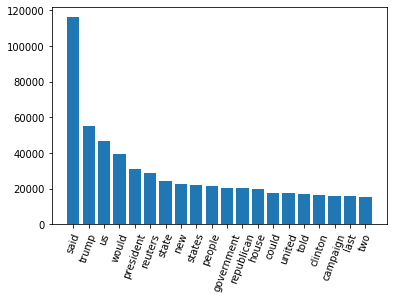

In [72]:
plt.bar(range(len(mc_real_text)), [val[1] for val in mc_real_text], align='center')
plt.xticks(range(len(mc_real_text)), [val[0] for val in mc_real_text])
plt.xticks(rotation=70)
plt.show()

In [73]:
#find the most common words in fake text (excluding stop words)
corpus_fakex = []
for i in range(len(ftx)):
    title = ftx.iloc[i]
    text_tokens = word_tokenize(title)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
    for j in range(len(tokens_without_sw)):
        corpus_fakex.append(tokens_without_sw[j])
print(corpus_fakex[:10])

['daniel', 'greenfield', 'shillman', 'journalism', 'fellow', 'freedom', 'center', 'new', 'york', 'writer']


In [74]:
#get the most common words used in real titles
from collections import Counter 
Counter_fakex = Counter(corpus_fakex) 
mc_fake_text = Counter_fakex.most_common(20) 
mc_fake_text

[('trump', 100328),
 ('us', 54179),
 ('people', 50569),
 ('said', 49700),
 ('would', 46127),
 ('clinton', 43282),
 ('president', 37464),
 ('like', 33141),
 ('hillary', 31768),
 ('new', 30557),
 ('obama', 27755),
 ('even', 27399),
 ('time', 26196),
 ('donald', 25579),
 ('state', 25085),
 ('news', 22472),
 ('many', 22098),
 ('could', 21815),
 ('election', 21135),
 ('media', 20815)]

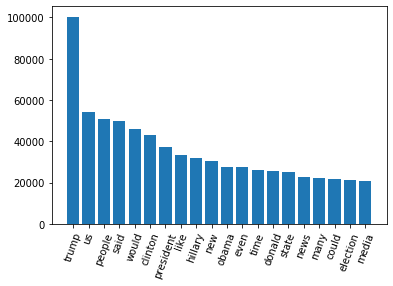

In [75]:
plt.bar(range(len(mc_fake_text)), [val[1] for val in mc_fake_text], align='center')
plt.xticks(range(len(mc_fake_text)), [val[0] for val in mc_fake_text])
plt.xticks(rotation=70)
plt.show()

### n-grams

In [76]:
#check ngrams in real title
(pd.Series(nltk.ngrams(corpus, 2)).value_counts())[:20]

(white, house)             848
(north, korea)             669
(trump, says)              373
(supreme, court)           279
(islamic, state)           255
(donald, trump)            190
(puerto, rico)             171
(says, us)                 163
(us, house)                161
(travel, ban)              155
(us, senate)               152
(hillary, clinton)         141
(nuclear, deal)            136
(new, york)                130
(factbox, trump)           129
(says, trump)              128
(south, korea)             126
(trump, administration)    125
(house, speaker)           118
(tax, bill)                114
dtype: int64

In [77]:
#check ngrams in fake title
(pd.Series(nltk.ngrams(corpus_fake, 2)).value_counts())[:20]

(donald, trump)        1038
(hillary, clinton)      800
(video, watch)          501
(president, trump)      434
(video, trump)          401
(white, house)          385
(fox, news)             329
(trump, video)          305
(bernie, sanders)       272
(video, breaking)       270
(trump, supporters)     247
(fake, news)            230
(trump, supporter)      229
(boiler, room)          205
(ted, cruz)             205
(supreme, court)        202
(lives, matter)         190
(bill, clinton)         187
(black, lives)          185
(president, obama)      178
dtype: int64

In [78]:
#check ngrams in real text
(pd.Series(nltk.ngrams(corpus_rx, 2)).value_counts())[:20]

(united, states)         13789
(white, house)            9864
(donald, trump)           9788
(washington, reuters)     6493
(president, donald)       5934
(new, york)               5778
(north, korea)            5319
(prime, minister)         4419
(trump, said)             4300
(said, statement)         4246
(islamic, state)          4132
(last, week)              3831
(hillary, clinton)        3778
(reuters, us)             3657
(last, year)              3555
(us, president)           3533
(told, reuters)           3512
(told, reporters)         3445
(said, would)             3368
(president, barack)       3238
dtype: int64

In [79]:
#check ngrams in fake text
(pd.Series(nltk.ngrams(corpus_fakex, 2)).value_counts())[:20]

(donald, trump)            22258
(hillary, clinton)         15469
(united, states)           12514
(white, house)              9669
(new, york)                 7338
(image, via)                6435
(president, obama)          4901
(fox, news)                 3923
(president, trump)          3882
(barack, obama)             3504
(secretary, state)          3300
(american, people)          2906
(law, enforcement)          2775
(national, security)        2714
(york, times)               2679
(obama, administration)     2678
(bill, clinton)             2655
(state, department)         2629
(clinton, campaign)         2626
(supreme, court)            2588
dtype: int64

### Word cloud analysis

In [80]:
from wordcloud import WordCloud, STOPWORDS

In [82]:
#wordcloud for real title

str_corpus = " "
for w in corpus:
    str_corpus += " " + str(w)

wordcloudrtitle = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(str_corpus) 

In [83]:
#wordcloud for fake title

str_corpus_fake = " "
for w in corpus_fake:
    str_corpus_fake += " " + str(w)

wordcloudftitle = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(str_corpus_fake) 

In [84]:
#wordcloud for real text

str_corpus_rx = " "
for w in corpus_rx:
    str_corpus_rx += " " + str(w)

wordcloudrxtext = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(str_corpus_rx) 

In [85]:
#wordcloud for fake text

str_corpus_fakex = " "
for w in corpus_fakex:
    str_corpus_fakex += " " + str(w)

wordcloudfxtext = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(str_corpus_fakex) 

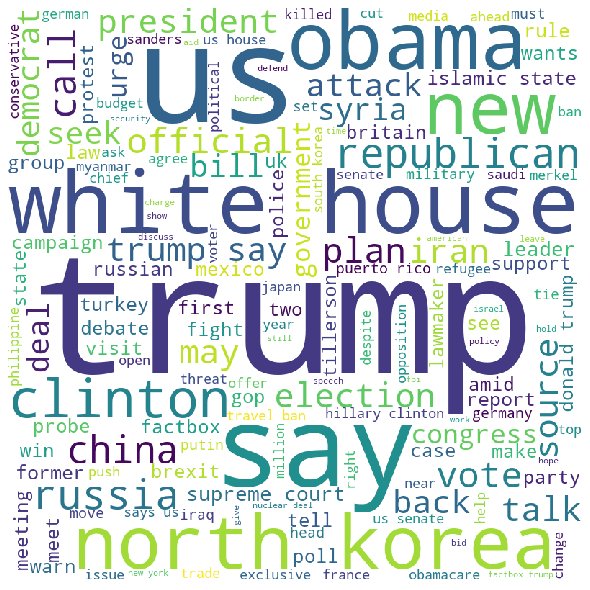

In [86]:
# plot the WordCloud image for real title                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloudrtitle) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

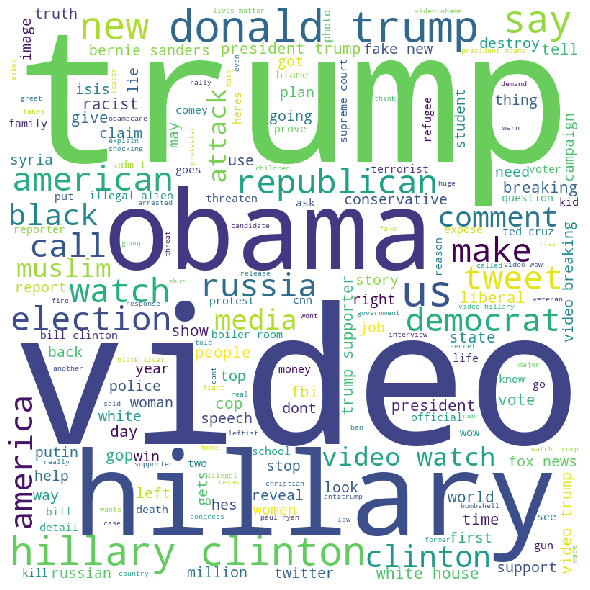

In [87]:
# plot the WordCloud image for fake title                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloudftitle) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

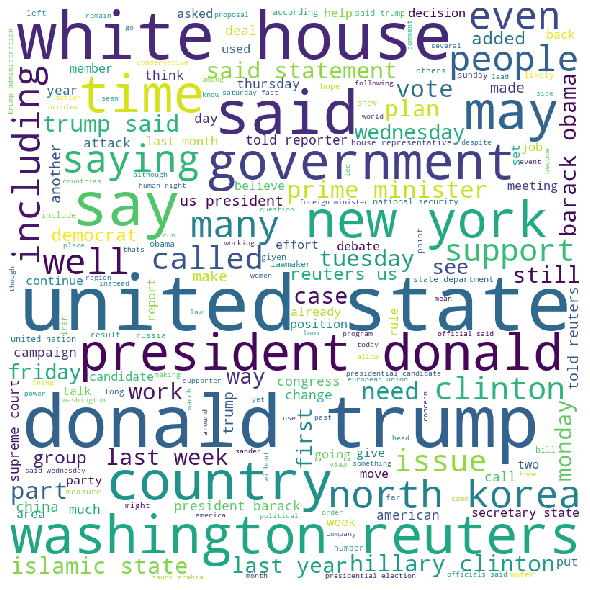

In [88]:
# plot the WordCloud image for real text                    
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloudrxtext) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

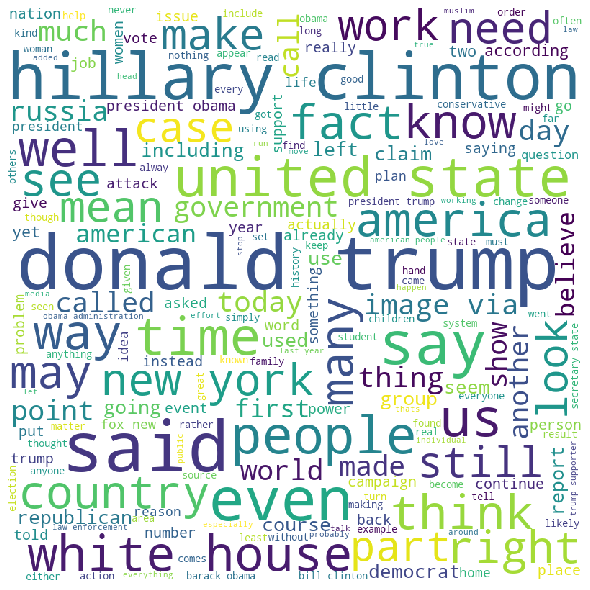

In [89]:
# plot the WordCloud image for fake text                      
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloudfxtext) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Pre-Processing

### Split into train and test

In [176]:
from sklearn.model_selection import train_test_split
import pickle
import bz2

In [201]:
# Joining the title column with the text column

df["text"] = df["new_title"] + " " + df["new_text"]

In [202]:
# dropping the old columns since they're not needed and making them a new DataFrame
df1 = df.drop(['new_title','new_text'], axis=1)

In [203]:
df1.head()

,label,title_char,text_char,title_word_count,text_word_count,text
0,FAKE,28,7518,5,749,you can smell hillarys fear daniel greenfield ...
1,FAKE,85,2646,14,259,watch the exact moment paul ryan committed pol...
2,REAL,43,2543,5,257,kerry go paris gesture sympathy us secretary s...
3,FAKE,84,2660,9,274,bernie supporters twitter erupt anger dnc we t...
4,REAL,48,1840,8,195,the battle new york why this primary matters i...


In [204]:
y = df1['label']
X = df1.drop(columns = ['label'])

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling

### TF-IDF
Term Frequency-Inverse document Frequency
Using the TfidfVectorizer to reduce the value of common words, while increasing the weight of words that do not occur in many documents. This normalizes the words in the document.

In [206]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Fit to train data

In [207]:
#Setting up the Tfidf Vectorizer
tv = TfidfVectorizer(max_features=100, stop_words='english')

In [208]:
train_tv_transformed = tv.fit_transform(X_train['text'])

In [209]:
train_tv_df = pd.DataFrame(train_tv_transformed.toarray(), columns=tv.get_feature_names()).add_prefix('TFIDF_')

In [210]:
sample_row = train_tv_df.iloc[0]
print(sample_row.sort_values(ascending=False).head())

TFIDF_national       0.446185
TFIDF_senate         0.379135
TFIDF_said           0.377452
TFIDF_republicans    0.352580
TFIDF_vote           0.256939
Name: 0, dtype: float64


### Apply to test data

In [211]:
test_tv_transformed = tv.transform(X_test['text'])

In [212]:
test_tv_df = pd.DataFrame(test_tv_transformed.toarray(), columns=tv.get_feature_names()).add_prefix('TFIDF_')

In [213]:
sample_row = test_tv_df.iloc[0]
print(sample_row.sort_values(ascending=False).head())

TFIDF_trump          0.637579
TFIDF_people         0.318704
TFIDF_country        0.317445
TFIDF_women          0.292121
TFIDF_republicans    0.262951
Name: 0, dtype: float64


In [217]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


We'll now apply the Passive Aggressive Classifer to it.

Passive signifies that if the classification is correct, we should keep the model. If it's aggressive then the classification is incorrect, update the model to adjust to more misclassified examples.

In [218]:
# Setting up Passive Aggressive Classifier
pac = PassiveAggressiveClassifier(max_iter = 50)

# Fitting on the training set
pac.fit(train_tv_transformed, y_train)

# Predicting on the test set
y_pred = pac.predict(test_tv_transformed)
score = accuracy_score(y_test, y_pred)

print(f'Accuracy: {round(score * 100, 2)}%')

Accuracy: 93.43%


## Support Vector Machines (SVM)